# Article Analysis

In [18]:
# show warnings only once
import warnings 

warnings.filterwarnings('ignore')

In [19]:
# load file
import pandas as pd
import os

current_dir = os.path.dirname(os.path.realpath('__file__'))
filepath = current_dir + '/csv/needed_article_titles_and_contents.csv'
df = pd.read_csv(filepath, delimiter = ";", names = ["title", "content"])
df.head()

title                                            content
0  Callianira hexagona  Callianira hexagona is a species of Ctenophora...
1   Ceratomyxa hooperi  Ceratomyxa hooperi is a myxosporean parasite t...
2          Bee removal  Bee removal is the process of removing bees fr...
3          Petalonamae  The Petalonamae are a proposed extinct group o...
4              Knacker  A Knacker (), Knackerman or Knacker Man, is a ...

#### Note
If you see the following window for the first time, please select "all" from the list and click "download". This may take a while. In consecutive runs you can simply close the window immediately. 

In [20]:
# load nltk
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [21]:
# tokenize documents
from nltk.tokenize import word_tokenize
import numpy as np

documents = df["content"].values

def tokenize(documents): 
    return np.array([nltk.word_tokenize(document) for document in documents])

tokens = tokenize(documents)
print(tokens[0][:10])

['Callianira', 'hexagona', 'is', 'a', 'species', 'of', 'Ctenophora', 'from', 'the', 'Mertensiidae']


In [22]:
# apply pos tagging
def tag_pos(documents): 
    return np.array([nltk.pos_tag(document) for document in documents])

pos_tags = tag_pos(tokens)
print(pos_tags[0][:10])

[('Callianira', 'NNP'), ('hexagona', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('species', 'NNS'), ('of', 'IN'), ('Ctenophora', 'NNP'), ('from', 'IN'), ('the', 'DT'), ('Mertensiidae', 'NNP')]


In [23]:
# filter nouns
def filter_nouns(documents): 
    return np.array([[pos_tag[0].lower() for pos_tag in document if pos_tag[1][0] == "N"] for document in documents])

nouns = filter_nouns(pos_tags)    
print(nouns[0])

['callianira', 'hexagona', 'species', 'ctenophora', 'mertensiidae', 'family', 'name', 'species', 'bruguière']


In [24]:
# lemmatization
from nltk.corpus import wordnet as wn

def lemmatize(documents): 
    return np.array([[wn.morphy(noun) for noun in document if wn.morphy(noun) != None]for document in documents])

lemmas = lemmatize(nouns)
print(lemmas[0]) 
    
def map_frequencies(documents): 
    frequencies = {}
    for document in documents: 
        for word in document: 
            if word in frequencies: 
                frequencies[word] += 1
            else: 
                frequencies[word] = 1
    return frequencies

# lemma_count = dict(zip(np.unique(np.hstack(lemmas).flatten(), return_counts = True)))
lemma_count = map_frequencies(lemmas)
print(lemma_count)

['species', 'ctenophora', 'family', 'name', 'species']
{'species': 9068, 'ctenophora': 38, 'family': 1827, 'name': 1260, 'parasite': 692, 'fish': 2285, 'great': 342, 'barrier': 184, 'reef': 721, 'epinephelus': 24, 'bee': 655, 'removal': 164, 'process': 751, 'location': 527, 'professional': 63, 'services': 188, 'purpose': 466, 'honey': 311, 'colony': 446, 'value': 272, 'crop': 310, 'pollination': 30, 'production': 885, 'beeswax': 15, 'characteristic': 386, 'pest': 315, 'control': 1000, 'beekeeper': 88, 'box': 220, 'cavity': 188, 'building': 274, 'block': 56, 'wall': 248, 'barrel': 20, 'tile': 5, 'roof': 32, 'bathroom': 8, 'ceiling': 15, 'play': 118, 'floor': 164, 'extension': 89, 'soffit': 1, 'property': 347, 'state': 2918, 'company': 541, 'work': 565, 'training': 307, 'education': 202, 'situation': 312, 'apis': 64, 'type': 1340, 'laboratory': 519, 'analysis': 356, 'group': 2525, 'animal': 11552, 'sister': 104, 'basal': 56, 'porifera': 25, 'knacker': 9, 'man': 453, 'job': 77, 'title': 1

## Hypothesis 1: Most frequent nouns
We expect words like "animal", "behavior", "habitat" and "diet" to be the most frequent words and also a few common animal names like "cat" and "dog". 

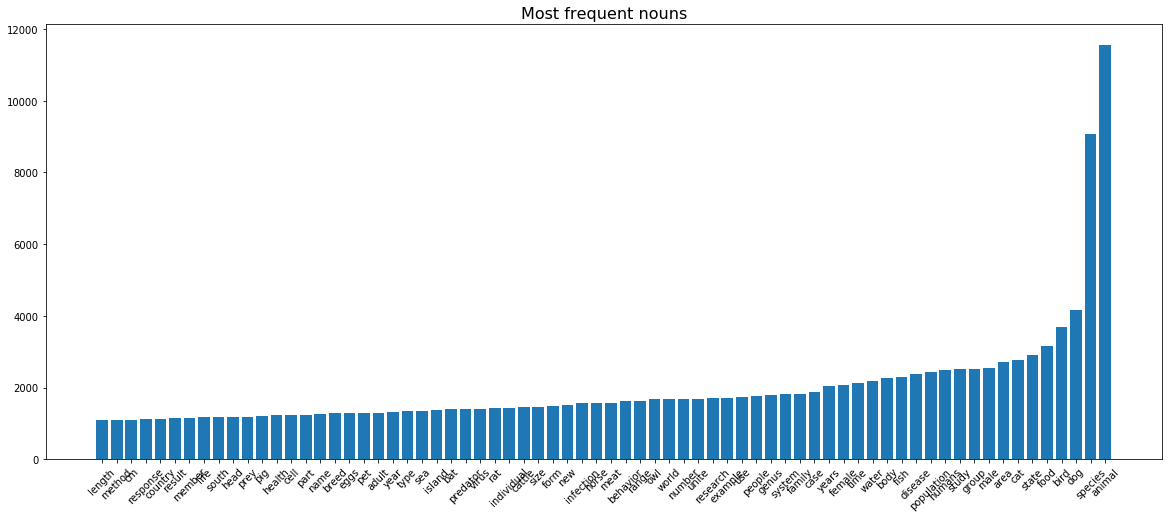

In [42]:
# visualize distribution
import matplotlib.pyplot as plt
%matplotlib inline

lemma_count_subset = {k: v for k, v in lemma_count.items() if v > 1100}
sorted_lemma = dict(sorted(lemma_count_subset.items(), key=lambda x: x[1]))

labels = list(sorted_lemma.keys())
values = list(sorted_lemma.values())

plt.figure(figsize = (20,8))
plt.title("Most frequent nouns", fontdict={'fontsize':16})
plt.bar(labels, values)
plt.xticks(rotation = 45)
plt.show()

## Evaluation of Hypothesis 1
We correctly guessed that "animal" belongs to the most frequent nouns (in fact, it is THE most frequent noun), but we missed "species", the second most frequent noun. "cat" and "dog" are also among the top words, but we didn't expect "bird" to occur more often than "cat". "diet" wasn't among the top words, but a similar one ("food") is. Interestingly, the term "male" occurs more often than "female". As we expected, "behavior" is also part of the most frequent nouns and "region" which probably correlates to "habitat" is also high on the top. 

In [30]:
# filter stopwords
def filter_stopwords(documents): 
    en_stop = set(nltk.corpus.stopwords.words('english'))
    docs = []
    for document in documents: 
        doc = []
        for word in document: 
            lemma = wn.morphy(word)
            condition = lemma not in en_stop and lemma != None and len(lemma) > 2
            if condition: 
                doc.append(lemma)
        docs.append(doc)
    return np.array(docs)
                
filtered = filter_stopwords(tokens)
print(filtered[0])

['species', 'family', 'scientific', 'name', 'species', 'first', 'publish']


In [31]:
# prepare data for LDA
import gensim 
dictionary = gensim.corpora.Dictionary(filtered)
corpus = [dictionary.doc2bow(document) for document in filtered]

print(dictionary)
print(corpus)

Dictionary(23770 unique tokens: ['family', 'first', 'name', 'publish', 'scientific']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2)], [(1, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(5, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 15), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 2), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 9), (79, 2), (80, 1), (81, 3), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1)

## Hypothesis 2: Topic Clusters
We expect topics to emerge from opposing contexts of animals like "pet" ("cat", "dog" and "human"), wild animals ("tiger", "predator" and "wild") and "cattle" ("cow", "pig" and "livestock"); and also clusters separating mammals from reptiles and terrestrial from aquatic and aerial animals. 

In [45]:
# build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word = dictionary, passes = 15, random_state = 28)
topics = ldamodel.print_topics(num_words = 4)
for topic in topics:
    print(topic)

(0, '0.015*"cattle" + 0.008*"slaughter" + 0.007*"cow" + 0.007*"also"')
(1, '0.013*"use" + 0.013*"bee" + 0.011*"snake" + 0.008*"space"')
(2, '0.033*"species" + 0.020*"fish" + 0.010*"genus" + 0.010*"found"')
(3, '0.025*"bird" + 0.014*"dolphin" + 0.013*"whale" + 0.010*"shark"')
(4, '0.044*"animal" + 0.010*"use" + 0.006*"state" + 0.006*"right"')
(5, '0.013*"breed" + 0.013*"cat" + 0.010*"use" + 0.009*"rabbit"')
(6, '0.013*"species" + 0.007*"may" + 0.006*"male" + 0.006*"female"')
(7, '0.013*"disease" + 0.011*"infection" + 0.010*"virus" + 0.009*"cause"')
(8, '0.018*"dog" + 0.011*"animal" + 0.008*"pet" + 0.008*"use"')
(9, '0.016*"owl" + 0.012*"bat" + 0.008*"elephant" + 0.008*"use"')


In [46]:
# visualize topics (using first three levels)
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics = False)
pyLDAvis.display(lda_display)

## Evaluation of Hypothesis 2
Cluster number 8 includes the words "disease", "infection" and "virus", describing cellular life which we didn't take into consideration. 
Cluster 3 covers what we called aquatic animals, with words like "fish", "reef" and "marine" but unfortunately not specific animals like "dolphin", "whale" or "shark". But they occur in the cluster 4 right next to it. 
And as we expected, a cluster about flying animals emerged (cluster 4) with words including "bird", "nest", "eggs", "hen" but not many specific animals like "owl" though it is one of the more common nouns. Also, the cluster contains aquatic animals. Maybe if more clusters were created, these two groups would have been separated. 
Cluster 9 describes another group we predicted, namely "pets" with words including "dog", "pet", "cat" and "human". Very similar words which we used to describe this cluster. 
Cluster 6, 7, and 10 roughly describe what we called "wild" animals consisting of  "elephant", "prey", "fox", and "predator". But it may also be that these clusters simply describe animals in general terms, since they also include words like "breeding", "domesticate", and domesticated or harmless animals like "horse" and "rabbit". 
Cluster 1 describes "cattle", with this name also being the most influencing word followed by "slaughter", "cow" but also "sacrifice" and "tradition", which shows the use of animals in a religious context which we didn't consider since it seemed rather niche to us. 
Lastly, cluster 5 surprised since it includes terms like "research", "right", "state" and "law", probably referencing the animal-rights movement because of livestock breeding and slaughter and using animals as test subjects in research. 

In [35]:
# using only topics from the first layer
level_map_path = "C:/Users/Anita/Desktop/data/level_map.csv"
level_map = pd.read_csv(level_map_path, delimiter = ";", names = ["level", "titles"])
level_map["level"] = [0,1,2]
level_map.head()

level                                             titles
0      0  Animals,Non-human,Eumetazoa,Interspecies_frien...
1      1  Mammals_by_year_of_formal_description,Insects_...
2      2  Magpie,Meadowlark,Flameback,Kestrel,Shearwater...

In [37]:
# visualize named entity distribution
def ner(documents): 
    named_entities = []
    for document in documents: 
        for sentence in nltk.sent_tokenize(document): 
            for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence))): 
                if hasattr(chunk, 'label'): 
                    chunkname = chunk.leaves()[0][0]
                    named_entities.append(chunkname)
    return np.array(named_entities)
                
named_entities = ner(documents)

In [38]:
def map_frequencies_ner(named_entities): 
    frequencies = {}
    for named_entity in named_entities: 
        if named_entity in frequencies: 
            frequencies[named_entity] += 1
        else: 
            frequencies[named_entity] = 1
    return frequencies
            
ne_count = map_frequencies_ner(named_entities)

## Hypothesis 3: Most frequent named entities
It is unlikely that a specific animal name is one of the top named entities. Rather, it could be locations since many different species live in one region. This could be described in terms of country or continent names (with continent names being more frequent) like "Africa", "Northern Australia" and "Russia" and landscape types like "desert", "tundra" and "rainforest". 

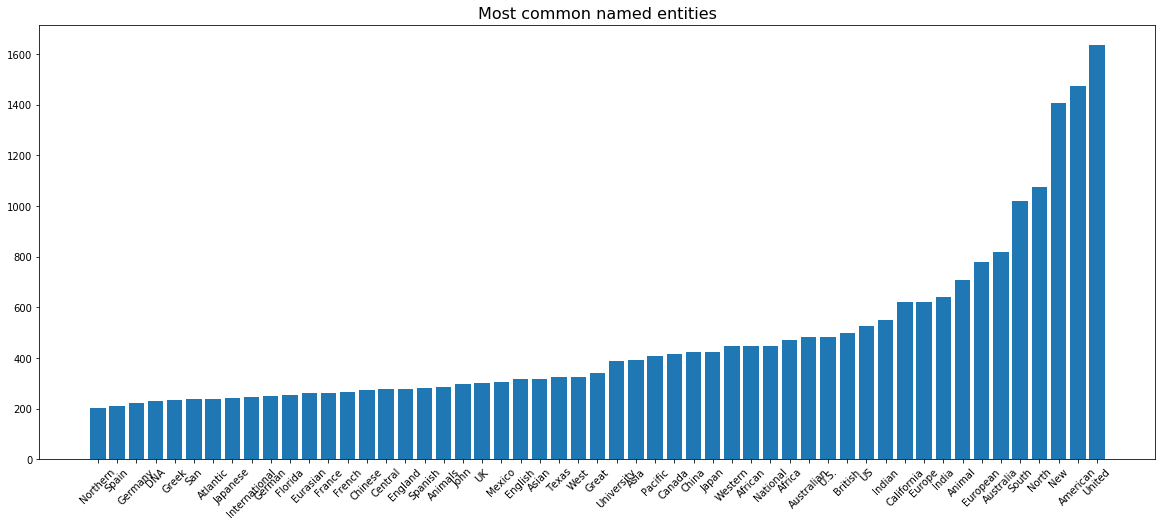

In [40]:
ne_count_subset = {k: v for k, v in ne_count.items() if v > 200}
sorted_ne = dict(sorted(ne_count_subset.items(), key=lambda x: x[1]))

labels = list(sorted_ne.keys())
values = list(sorted_ne.values())

plt.figure(figsize = (20,8))
plt.title("Most common named entities", fontdict={'fontsize':16})
plt.bar(labels, values)
plt.xticks(rotation = 45)
plt.show()

## Evaluation of Hypothesis 3
The guess that locations are among the most frequent named entities was right. In fact, there not a single animal name included contrary to our assumption (we expected at least a few names at the lower end). It's correct that rough region descriptions are among the top words and country names lower on the list. But the words "North" and "South" are probably missing the following country or region name so they should either be discarded or used in conjunction with the following word. 

# Further research
It would be interesting to see what topics emerge if lower levels are also taken into consideration. Furthermore, looking at separate levels more in detail shows how the topics slowly diverge. 
If one has the computational power and time, generating more clusters might deliver some interesting results and more "niche" clusters. 
Also, trying to preserve depencendies between names as we saw for the regions ("North" not being followed by a country or continent name") could more show if specific regions are mentioned more frequently than others. 
